In [6]:
from datetime import datetime

from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter
from pytket.utils.operators import QubitPauliOperator
from pytket.partition import measurement_reduction, MeasurementBitMap, MeasurementSetup, PauliPartitionStrat
from pytket.backends.backendresult import BackendResult
from pytket.pauli import Pauli, QubitPauliString
from pytket.circuit import Qubit

from scipy.optimize import minimize
from numpy import ndarray
from numpy.random import random_sample
from sympy import Symbol
from functools import partial

import qnexus as qnx
from copy import deepcopy
import matplotlib.pyplot as plt


In [13]:
# qibo's
import qibo
from qibo import gates, hamiltonians, models
from qibo.backends import GlobalBackend
from qibo.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)


# boostvqe's
from boostvqe import ansatze
from boostvqe.plotscripts import plot_gradients, plot_loss
from boostvqe.training_utils import Model, vqe_loss
from boostvqe.utils import (
    DBI_D_MATRIX,
    DBI_ENERGIES,
    DBI_FLUCTUATIONS,
    DBI_STEPS,
    FLUCTUATION_FILE,
    GRADS_FILE,
    HAMILTONIAN_FILE,
    LOSS_FILE,
    SEED,
    TOL,
    apply_dbi_steps,
    create_folder,
    generate_path,
    results_dump,
    rotate_h_with_vqe,
    train_vqe,
)
import numpy as np

# TFIM model

Our goal here is to run VQE on the TFIM model, defined as
$$
H_{\text{TFIM}} = -\sum_i Z_iZ_{i+1} + h\sum_i X_i
$$

By the Central Limit Theorem, the error (standard deviation) of the expectation value $\langle  H_{\text{TFIM}}\rangle$ scales with $1/\sqrt{N_{\text{shots}}}$. In this notebook, we will show

1. The VQE result of the TFIM model on 5-10 qubits.
2. How the error scales with number of shots.
3. How the error scales with the size of the system $L$.

In [8]:
# basics
nqubits = 5
h = 3

In [9]:
# helper functions
def exact_expectation_boost(ham, circ):
    # calculates the exact expectation of hamiltonian given a circuit in qibo
    return ham.expectation(
        ham.backend.execute_circuit(circuit=circ).state())

# Boostvqe

In [10]:
qibo.set_backend("tensorflow")

[Qibo 0.2.12|INFO|2024-10-11 14:49:58]: Using tensorflow backend on /device:CPU:0
INFO:qibo.config:Using tensorflow backend on /device:CPU:0


In [11]:
# build hamiltonian
ham_boost = hamiltonians.TFIM(nqubits=nqubits, h=h, dense=False)
print(ham_boost.matrix)

[Qibo 0.2.12|WARNING|2024-10-11 14:49:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


tf.Tensor(
[[-5.+0.j -3.+0.j -3.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [-3.+0.j -1.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [-3.+0.j  0.+0.j -1.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ... -1.+0.j  0.+0.j -3.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j -1.+0.j -3.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ... -3.+0.j -3.+0.j -5.+0.j]], shape=(32, 32), dtype=complex128)


In [14]:
# build ansatz circuit
nlayer = 1
ansatz_circ = ansatze.hdw_efficient(nqubits, nlayer)
print(ansatz_circ.draw())

[Qibo 0.2.12|WARNING|2024-10-11 14:50:14]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0: ─RY─RZ─o───RY─RZ───o─RY─
q1: ─RY─RZ─Z───RY─RZ─o─|─RY─
q2: ─RY─RZ───o─RY─RZ─Z─|─RY─
q3: ─RY─RZ───Z─RY─RZ───|─RY─
q4: ─RY─RZ─────RY─RZ───Z─RY─


In [15]:
# build zero state
zero_state = ham_boost.backend.zero_state(nqubits)
# initial params
params_len = len(ansatz_circ.get_parameters())
# fix numpy seed to ensure replicability of the experiment
seed = 10
np.random.seed(seed)
initial_params = np.random.uniform(-np.pi, np.pi, params_len)
print(initial_params)
# initial energy
c0 = deepcopy(ansatz_circ)
c0.set_parameters(initial_params)
target_energy = np.real(np.min(np.asarray(ham_boost.eigenvalues())))
print('Target enegry:', target_energy)
print('Initial energy:', exact_expectation_boost(ham_boost, c0))

[ 1.70475788 -3.01120431  0.83973663  1.5632809  -0.00938072 -1.72915367
 -1.89712697  1.63696274 -2.07903793 -2.58653723  1.16465009  2.84875441
 -3.11678496  0.07660625  1.96425543  0.70702213  1.39332975 -1.30768123
  2.62495223  1.34821941  0.26731415 -2.2483119  -0.79582348  1.09411377
 -0.36547294]
Target enegry: -15.422871679540702
Initial energy: tf.Tensor(-2.651967569509104, shape=(), dtype=float64)


In [16]:
niter = 3
# define the qibo loss function
objective_boost = partial(vqe_loss)
# logging hisotry
params_history, loss_history, grads_history, fluctuations = [], [], [], []
# set optimizer
optimizer = 'sgd'
tol = 1e-2

In [17]:
# train vqe
(
    partial_results,
    partial_params_history,
    partial_loss_history,
    partial_grads_history,
    partial_fluctuations,
    vqe,
) = train_vqe(
    deepcopy(ansatz_circ),
    ham_boost,  # Fixed hamiltonian
    optimizer,
    initial_params,
    tol=tol,
    niterations=1,
    nmessage=1,
    loss=objective_boost,
    training_options={'nepochs':30,}
)
params_history = np.array(partial_params_history)
loss_history = np.array(partial_loss_history)
grads_history = np.array(partial_grads_history)
fluctuations = np.array(partial_fluctuations)

INFO:root:Optimization iteration 0/1
INFO:root:Loss -2.652
INFO:root:Minimize the energy
INFO:root:Optimization iteration 1/1
INFO:root:Loss -2.6775
INFO:root:Optimization iteration 2/1
INFO:root:Loss -2.6958
[Qibo 0.2.12|INFO|2024-10-11 14:50:24]: ite 1 : loss -2.677452
INFO:qibo.config:ite 1 : loss -2.677452
INFO:root:Optimization iteration 3/1
INFO:root:Loss -2.7109
INFO:root:Optimization iteration 4/1
INFO:root:Loss -2.724
INFO:root:Optimization iteration 5/1
INFO:root:Loss -2.7358
INFO:root:Optimization iteration 6/1
INFO:root:Loss -2.7465
INFO:root:Optimization iteration 7/1
INFO:root:Loss -2.7565
INFO:root:Optimization iteration 8/1
INFO:root:Loss -2.7658
INFO:root:Optimization iteration 9/1
INFO:root:Loss -2.7746
INFO:root:Optimization iteration 10/1
INFO:root:Loss -2.783
INFO:root:Optimization iteration 11/1
INFO:root:Loss -2.7909
INFO:root:Optimization iteration 12/1
INFO:root:Loss -2.7985
INFO:root:Optimization iteration 13/1
INFO:root:Loss -2.8059
INFO:root:Optimization ite

Text(0, 0.5, 'param difference')

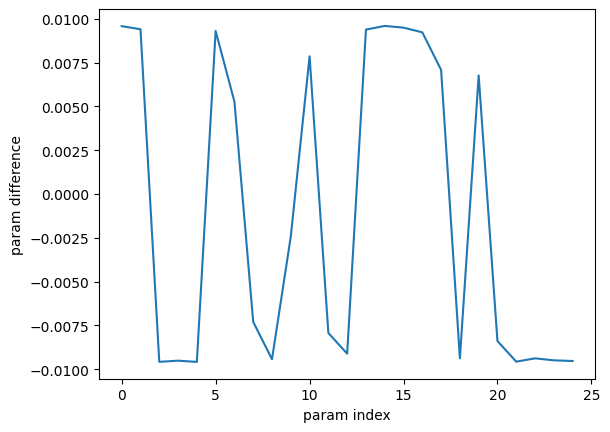

In [18]:
newest_param = params_history[-1]
plt.plot(newest_param-initial_params)
plt.xlabel('param index')
plt.ylabel('param difference')

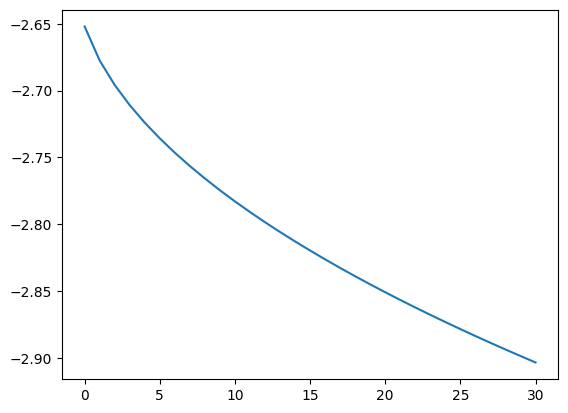

In [19]:
plt.plot(loss_history)

In [20]:
# the final circuit
c1 = deepcopy(ansatz_circ)
c1.set_parameters(params_history[-1])

# Quantinuum

In [21]:
qnx.client.auth.login_with_credentials()

INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/auth/login "HTTP/1.1 200 OK"


✅ Successfully logged in as xiaoyue.li@ntu.edu.sg.


In [22]:
# Connect to project
project_ref = qnx.projects.get_or_create(name="TFIM_experiment(VQE)")
project_ref.df()

# set this in the context
qnx.context.set_active_project(project_ref)

INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/projects/v1beta/meta/count?filter%5Barchived%5D=false&filter%5Btimestamps%5D%5Bcreated%5D%5Bafter%5D=2023-01-01%2000%3A00%3A00&filter%5Bname%5D=TFIM_experiment%28VQE%29 "HTTP/1.1 401 Unauthorized"
INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/auth/tokens/refresh "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/projects/v1beta/meta/count?filter%5Barchived%5D=false&filter%5Btimestamps%5D%5Bcreated%5D%5Bafter%5D=2023-01-01%2000%3A00%3A00&filter%5Bname%5D=TFIM_experiment%28VQE%29 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/projects/v1beta?filter%5Barchived%5D=false&filter%5Btimestamps%5D%5Bcreated%5D%5Bafter%5D=2023-01-01%2000%3A00%3A00&filter%5Bname%5D=TFIM_experiment%28VQE%29&page%5Bnumber%5D=0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/projects/v1beta?filter%5Barchived%5D=false&filter%5Btimestamps%5D%5Bcreated%

In [23]:
# helper functions
def create_qubit_pauli_string(nqubits, specify_ls, coef):
    '''
    specify_ls: {index:Pauli.X/Y/Z}
    '''
    term = {}
    specified_ids = list(specify_ls.keys())
    for i in range(nqubits):
        if i in specified_ids:
            term.update({Qubit(i):specify_ls[i]})
        else:
            term.update({Qubit(i):Pauli.I})

    return {QubitPauliString(term):coef}

In [24]:
terms = {}
for i in range(nqubits):
    term_x_i = create_qubit_pauli_string(nqubits, {i: Pauli.Z, (i+1)%nqubits: Pauli.Z}, -1)
    term_z_i = create_qubit_pauli_string(nqubits, {i: Pauli.X}, -h)
    terms.update(term_x_i)
    terms.update(term_z_i)
ham_quantinuum = QubitPauliOperator(terms)

In [25]:
print(ham_quantinuum)

{(Zq[0], Zq[1], Iq[2], Iq[3], Iq[4]): -1, (Xq[0], Iq[1], Iq[2], Iq[3], Iq[4]): -3, (Iq[0], Zq[1], Zq[2], Iq[3], Iq[4]): -1, (Iq[0], Xq[1], Iq[2], Iq[3], Iq[4]): -3, (Iq[0], Iq[1], Zq[2], Zq[3], Iq[4]): -1, (Iq[0], Iq[1], Xq[2], Iq[3], Iq[4]): -3, (Iq[0], Iq[1], Iq[2], Zq[3], Zq[4]): -1, (Iq[0], Iq[1], Iq[2], Xq[3], Iq[4]): -3, (Zq[0], Iq[1], Iq[2], Iq[3], Zq[4]): -1, (Iq[0], Iq[1], Iq[2], Iq[3], Xq[4]): -3}


In [26]:
# measurement setup
terms = [term for term in ham_quantinuum._dict.keys()]
measurement_setup = measurement_reduction(
    terms, strat=PauliPartitionStrat.CommutingSets
)
for mc in measurement_setup.measurement_circs:
    render_circuit_jupyter(mc)

# Calculating the expectation energy

TODO: latex here

In [27]:
def compute_expectation_paulistring(
    distribution: dict[tuple[int, ...], float], bitmap: MeasurementBitMap
) -> float:
    '''
    This function assumes that the bitmap is in the correct measurement basis
    and evaluates Pauli operators composed of Pauli.Z and Pauli.I.
    It calculates the expectation by counting the parity of the qubits being
    flipped.
    '''
    value = 0
    for bitstring, probability in distribution.items():
        value += probability * (sum(bitstring[i] for i in bitmap.bits) % 2)
    return ((-1) ** bitmap.invert) * (-2 * value + 1)

In [28]:
def compute_expectation_value_from_results(
    results: list[BackendResult],
    measurement_setup: MeasurementSetup,
    operator: QubitPauliOperator,
) -> float:
    '''
    This function loops with the measurement_setup corresponding to the
    hamiltonian, select the corresponding string_coef, results index and
    calculates the total expectation of the input hamiltonian.
    '''
    energy = 0
    for pauli_string, bitmaps in measurement_setup.results.items():
        string_coeff = operator.get(pauli_string, 0.0)
        if string_coeff != 0:
            for bm in bitmaps:
                index = bm.circ_index
                distribution = results[index].get_distribution()
                value = compute_expectation_paulistring(distribution, bm)
                energy += complex(value * string_coeff).real
    return energy

Let's test the correctness of the above setup by calculating the initial energy of the hamiltonian wrt to the vqe ansatz circuit. Before that, we need to convert the ansatz circuit into pytket.

In [29]:
c1_qasm = models.Circuit.to_qasm(c1)

In [30]:
import pytket.qasm
c1_tket = pytket.qasm.circuit_from_qasm_str(c1_qasm)
render_circuit_jupyter(c1_tket)

## Compare the converted circuits

In [31]:
print(c1.unitary())
print(c1_tket.get_unitary())
print(np.abs(c1_tket.get_unitary()-c1.unitary()))

tf.Tensor(
[[ 8.21331126e-02-0.00724065j  1.22344171e-01+0.01843613j
  -5.20937976e-02-0.02936033j ...  3.59148421e-01+0.29964324j
  -1.42429181e-01-0.02220146j -2.04865408e-01-0.07543219j]
 [ 1.66296148e-02+0.09581972j -8.55156517e-03-0.06659932j
   3.67537240e-02-0.06836477j ...  1.36035398e-01-0.24090536j
   1.30156114e-02-0.19146669j -2.05656636e-02+0.12695211j]
 [ 9.63111240e-03+0.03958416j  4.08843853e-03+0.06148622j
  -6.45388398e-02+0.02428923j ...  2.85054485e-02-0.0914907j
  -2.18345431e-01-0.17139094j -2.75385844e-01-0.31923501j]
 ...
 [-1.19736943e-01+0.02368511j  6.02692964e-02+0.0514377j
   2.90787597e-01+0.36028478j ... -4.56010998e-02+0.03796793j
  -5.05526714e-02-0.03671086j  2.26207952e-04+0.04355049j]
 [ 2.30717239e-01-0.18071441j  4.15024079e-01+0.16060118j
   1.44303543e-01-0.04448232j ... -1.01988650e-01-0.02560909j
  -7.51903658e-02+0.03331252j -1.01992018e-01-0.06910349j]
 [-2.47776795e-01-0.45274936j -1.33466814e-01+0.30793151j
  -3.35038816e-02-0.26312228j ...

In [32]:
# upload state prep vqe circuit to project
vqe_circ = qnx.circuits.upload(
    circuit=c1_tket,
    name="vqe_circ",
    description="The VQE circuit obtained from running VQE in QIBO",
)

INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/api/circuits/v1beta "HTTP/1.1 201 Created"


In [33]:
# create list of circuits for measurement in different bases
circuit_ref_list = []
for i, mc in enumerate(measurement_setup.measurement_circs):
    c = c1_tket.copy()
    c.append(mc)
    measurement_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement circuit {i}",
            )
    circuit_ref_list.append(measurement_circuit_ref)
    
# compile measurement circuit list
compiled_circuit_refs = qnx.compile(
            name=f"compile_job_VQE_{datetime.now()}",
            circuits=circuit_ref_list,
            optimisation_level=2,
            backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
            timeout=None,
        )

INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/api/circuits/v1beta "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/api/circuits/v1beta "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/api/jobs/v1beta "HTTP/1.1 202 Accepted"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/jobs/v1beta/534fbf88-ed4c-4ab2-919d-95df677cd30c/attributes/status "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/jobs/v1beta/534fbf88-ed4c-4ab2-919d-95df677cd30c "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/compilations/v1beta/1c4d32ef-22dc-46a9-9ab9-04aedb0527ff "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/compilations/v1beta/c87a058b-3458-428b-a9a6-e5f0da139f4f "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/compilations/v1beta/1c4d32ef-22dc-46a9-9ab9-04aedb0527ff "HTTP/1.1 200 OK"
INFO:httpx

In [34]:
nshots = 500
target_backend = qnx.QuantinuumConfig(device_name="H1-1LE")

In [36]:
results = qnx.execute(
            name=f"execute_job_VQE_{datetime.now()}",
            circuits=compiled_circuit_refs,
            n_shots=[nshots]*len(circuit_ref_list),
            backend_config=target_backend,
            timeout=None,
        )

expval = compute_expectation_value_from_results(
    results, measurement_setup, ham_quantinuum
)

INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/api/jobs/v1beta "HTTP/1.1 401 Unauthorized"
INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/auth/tokens/refresh "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/api/jobs/v1beta "HTTP/1.1 202 Accepted"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/jobs/v1beta/e1123f2f-da48-4ae2-9c18-6db8fda14757/attributes/status "HTTP/1.1 200 OK"


KeyboardInterrupt: 

In [35]:
expval = compute_expectation_value_from_results(
    results, measurement_setup, ham_quantinuum
)
print(expval)

NameError: name 'results' is not defined

# Readout problem

By the central limit theorem, we know that provided enough independent identical trials, the statistics tend to a normal distribution. More over, the standard deviation (error), scales with $1/\sqrt {N}$. This means that, in order to achieve a low error from the readout results, a large number of trials will be required, and as the precision increases, the number of shots required grows rapidly.

In this section, we want to show that this trend exists. Afterwards, we will see how this effect is affected by the presence of noise.

In [243]:
# shots_list = np.linspace(500,10000,20)
# loss_list = []
# for nshots in shots_list:
#     results = qnx.execute(
#             name=f"execute_job_VQE_{datetime.now()}",
#             circuits=compiled_circuit_refs,
#             n_shots=[int(nshots)]*len(circuit_ref_list),
#             backend_config=target_backend,
#             timeout=None,
#         )

#     expval = compute_expectation_value_from_results(
#         results, measurement_setup, ham_quantinuum
#     )
#     loss_list.append(expval)

INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/api/jobs/v1beta "HTTP/1.1 401 Unauthorized"
INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/auth/tokens/refresh "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/api/jobs/v1beta "HTTP/1.1 202 Accepted"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/jobs/v1beta/ef8e17f3-ed72-45fe-95bf-fec53b602c4b/attributes/status "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/jobs/v1beta/ef8e17f3-ed72-45fe-95bf-fec53b602c4b "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/results/v1beta/e9231b08-7fdc-498a-897e-bae41645284c "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/circuits/v1beta/3b062a73-1c0c-48e6-97fe-92cd18fa060e "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/results/v1beta/42b68c7c-25b7-44d2-ad2b-944dd767f882 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET

Text(0, 0.5, 'percentage error')

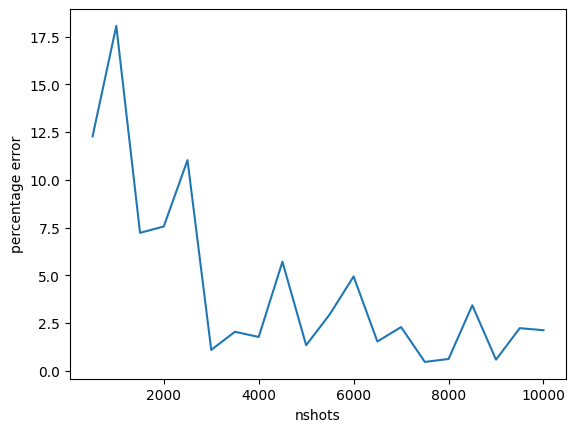

In [246]:
# target = loss_history[-1]
# percent_error = [np.abs(loss-target)/np.abs(target)*100 for loss in loss_list]
# plt.plot(shots_list, percent_error)
# plt.xlabel('nshots')
# plt.ylabel('percentage error')

## More comprehensive analysis
In this section, we will make the last plot more systematic by adding more data points and analyse the mean trend and variance.

In [41]:
pts_per_shots = 20
shots_list = np.linspace(500,10000,10)
loss_list = []
for nshots in shots_list:
    ls_nshots = []
    for pts in range(pts_per_shots):
        results = qnx.execute(
                name=f"execute_job_VQE_{datetime.now()}",
                circuits=compiled_circuit_refs,
                n_shots=[int(nshots)]*len(circuit_ref_list),
                backend_config=target_backend,
                timeout=None,
            )

        expval = compute_expectation_value_from_results(
            results, measurement_setup, ham_quantinuum
        )
        ls_nshots.append(expval)
    loss_list.append(ls_nshots)

INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/api/jobs/v1beta "HTTP/1.1 401 Unauthorized"
INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/auth/tokens/refresh "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/api/jobs/v1beta "HTTP/1.1 202 Accepted"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/jobs/v1beta/545eed6c-7ab2-4851-8135-134cb7e999f4/attributes/status "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/jobs/v1beta/545eed6c-7ab2-4851-8135-134cb7e999f4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/results/v1beta/ee40e055-0622-46ec-b7ff-8c0b6363b3df "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/circuits/v1beta/e679abaf-2ef5-4890-a170-140d6cf43d6e "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/results/v1beta/14e9e42f-0ac8-4205-a6e9-042e71c43485 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET

In [43]:
print(loss_list)

[[-3.2719999999999985, -2.44, -3.663999999999999, -2.5999999999999983, -2.892, -3.5279999999999987, -3.1279999999999983, -3.055999999999999, -2.875999999999999, -2.863999999999998, -2.923999999999999, -3.147999999999999, -3.091999999999998, -2.967999999999998, -3.4639999999999986, -2.8279999999999994, -2.631999999999999, -4.0, -2.5599999999999987, -2.8719999999999994], [-2.794855305466239, -2.874598070739549, -3.0778135048231516, -2.8051446945337624, -2.9697749196141485, -3.1742765273311897, -3.0636655948553067, -2.5646302250803847, -2.9080385852090043, -2.8244372990353717, -3.1305466237942126, -2.9633440514469456, -2.411575562700965, -3.1755627009646306, -3.381350482315113, -2.9787781350482305, -2.838585209003215, -2.915755627009646, -2.7382636655948547, -3.0983922829581996], [-2.873228648027576, -2.8716966679433176, -2.9153581003446956, -2.92225201072386, -2.8824205285331295, -2.9375718115664498, -3.13213328226733, -2.828801225584067, -3.0271926464955965, -3.0187667560321705, -2.7866

In [48]:
mean_ls = [abs(np.mean(ls)-loss_history[-1]) for ls in loss_list]
std_ls = [np.std(ls) for ls in loss_list]

<ErrorbarContainer object of 3 artists>

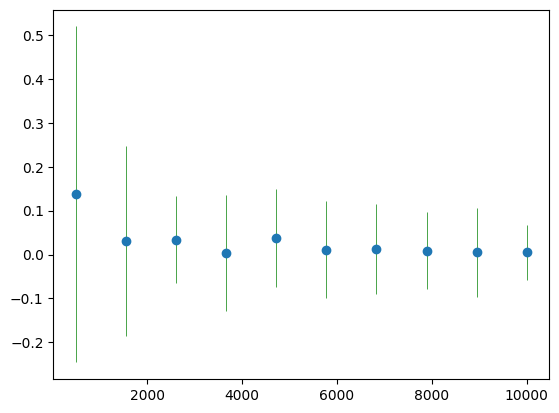

In [54]:
plt.errorbar(shots_list,mean_ls, yerr=std_ls, fmt='o', ecolor='green', elinewidth=0.5)

# Run locally without noise

In [97]:
target_backend = qnx.QuantinuumConfig(device_name="H1-1LE")

In [105]:
# initial runs
pts_per_shots = 10
shots_list = np.linspace(200,5200,10)
loss_list = []
for i, nshots in enumerate(shots_list):
    ls_nshots = []
    for pts in range(pts_per_shots):
        results = qnx.execute(
                name=f"execute_job_VQE_{datetime.now()}",
                circuits=compiled_circuit_refs,
                n_shots=[int(nshots)]*len(circuit_ref_list),
                backend_config=target_backend,
                timeout=None,
            )

        expval = compute_expectation_value_from_results(
            results, measurement_setup, ham_quantinuum
        )
        ls_nshots.append(expval)
    loss_list.append(ls_nshots)

INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/api/jobs/v1beta "HTTP/1.1 401 Unauthorized"
INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/auth/tokens/refresh "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/api/jobs/v1beta "HTTP/1.1 202 Accepted"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/jobs/v1beta/1b4165fe-70f5-47ac-a35e-2d65d7c742e7/attributes/status "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/jobs/v1beta/1b4165fe-70f5-47ac-a35e-2d65d7c742e7 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/results/v1beta/96ebceba-a46d-4a79-b08e-bc47a8baf97c "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/circuits/v1beta/e679abaf-2ef5-4890-a170-140d6cf43d6e "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/results/v1beta/5edafd94-f6fc-4c8d-8c83-b2e8b8a3e275 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET

In [106]:
for i in range(10):
    print(i, len(loss_list[i]))

0 10
1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10


In [107]:
mean_ls = [abs(np.mean(ls)-loss_history[-1]) for ls in loss_list]
std_ls = [np.std(ls) for ls in loss_list]
print(mean_ls)
print(std_ls)

[0.10057646544058585, 0.08927121667862181, 0.10756007155407765, 0.026970158353628815, 0.07145425239351555, 0.013082679750291426, 0.06242163951360924, 0.01080709620325182, 0.09224610131221489, 0.06580814994403106]
[0.35886069720714736, 0.2969908584769218, 0.20031597391857825, 0.1441439247891709, 0.20328958842286352, 0.17225013450467735, 0.13165105193430213, 0.14891358539716817, 0.05758212069214241, 0.0826066103348026]


<ErrorbarContainer object of 3 artists>

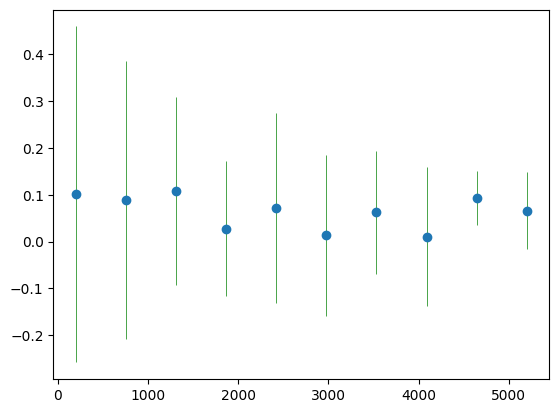

In [108]:
plt.errorbar(shots_list,mean_ls, yerr=std_ls, fmt='o', ecolor='green', elinewidth=0.5)

In [116]:
# append more runs
pts_per_shots = 10
shots_list = np.linspace(200,5200,10)
for i, nshots in enumerate(shots_list):
    j = i+0
    ls_nshots = []
    for pts in range(pts_per_shots):
        results = qnx.execute(
                name=f"execute_job_VQE_{datetime.now()}",
                circuits=compiled_circuit_refs,
                n_shots=[int(nshots)]*len(circuit_ref_list),
                backend_config=target_backend,
                timeout=1000,
            )

        expval = compute_expectation_value_from_results(
            results, measurement_setup, ham_quantinuum
        )
        ls_nshots.append(expval)
    loss_list[j].extend(ls_nshots)

INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/api/jobs/v1beta "HTTP/1.1 401 Unauthorized"
INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/auth/tokens/refresh "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://nexus.quantinuum.com/api/jobs/v1beta "HTTP/1.1 202 Accepted"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/jobs/v1beta/a659bb5e-9420-462c-9744-83d3b3580f0c/attributes/status "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/jobs/v1beta/a659bb5e-9420-462c-9744-83d3b3580f0c "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/results/v1beta/eaf77f32-a022-4774-94ed-fbf0ee970b51 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/circuits/v1beta/e679abaf-2ef5-4890-a170-140d6cf43d6e "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://nexus.quantinuum.com/api/results/v1beta/03b3e8f7-09da-425b-a36c-5f77f5511e5d "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET

In [117]:
for i in range(10):
    print(i, len(loss_list[i]))

0 100
1 100
2 100
3 100
4 100
5 100
6 100
7 100
8 100
9 100


In [119]:
mean_ls = [abs(np.mean(ls)-loss_history[-1]) for ls in loss_list]
std_ls = [np.std(ls) for ls in loss_list]
print(mean_ls)
print(std_ls)

[0.12132353455941436, 0.0017215478044496635, 0.027314070322352446, 0.011235967571206817, 0.00662171787898691, 0.01668362029446424, 0.021912157487002926, 0.0013455456754178918, 0.003877929695536242, 0.009085073020955292]
[0.519849006924126, 0.2852824864954109, 0.23803730163417935, 0.16795236013887485, 0.18024339580444382, 0.16136365521171064, 0.13951739477722802, 0.1327880170245532, 0.11850685154050711, 0.1113006972444492]


<ErrorbarContainer object of 3 artists>

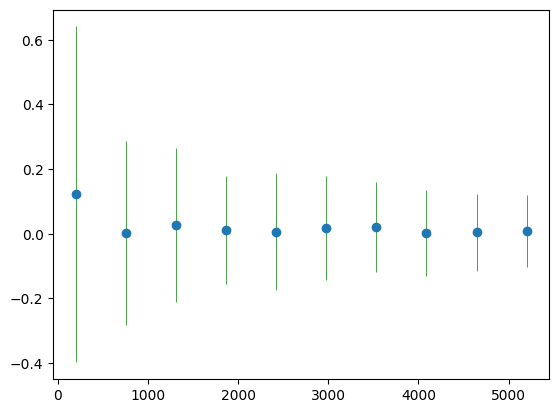

In [122]:
plt.errorbar(shots_list,mean_ls, yerr=std_ls, fmt='o', ecolor='green', elinewidth=0.5)
# plt.yscale('log')

In [159]:
def run_param_rc(fontsize = 15):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['mathtext.fontset'] = 'stix'
        plt.rcParams['font.family'] = 'STIXGeneral'
        plt.rcParams['font.serif'] = "cm"

In [162]:
run_param_rc()
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [167]:
from scipy.optimize import curve_fit
def power_law(i, c, a):
    return c * i**a

def fit_over_sqrt(i, c):
    return c * i ** (-0.5)

# Perform a curve fit on the data
params, covariance = curve_fit(fit_over_sqrt, shots_list, std_ls)

# Extract the fitted parameters
fitted_c = params

# Generate the fitted curve
fitted_y_vals = fit_over_sqrt(shots_list, fitted_c)
print(fitted_c)

[7.72895397]


/var/folders/sn/4ym_qb8x0cs_f961d78kvvkc0000gn/T/ipykernel_269/3750319259.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.

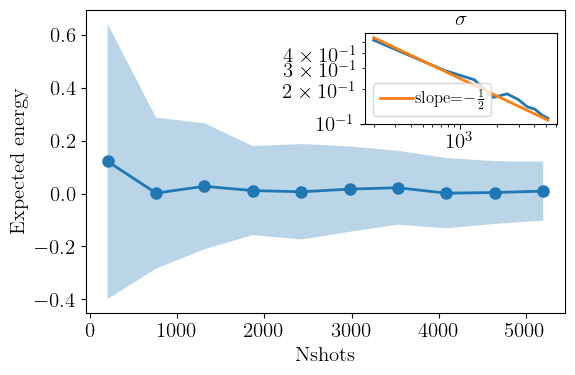

In [194]:
fig, ax = plt.subplots(figsize=(6, 4))
mean_ls = np.asarray(mean_ls)
std_ls = np.asarray(std_ls)
ax.plot(shots_list, mean_ls, 'o-', label='Mean')
ax.fill_between(shots_list, mean_ls - std_ls, mean_ls + std_ls, alpha=0.3)
ax.set_xlabel('Nshots')
ax.set_ylabel('Expected energy')
inset_ax = inset_axes(ax, width="40%", height="30%", loc='upper right', 
                      bbox_to_anchor=(0, -0.05, 1, 1),  # Adjust the values to move the inset
                      bbox_transform=ax.transAxes) 
inset_ax.plot(shots_list, std_ls)
inset_ax.plot(shots_list, [fitted_c * shot ** (-0.5) for shot in shots_list], label=r'slope=$-\frac{1}{2}$')
inset_ax.set_yscale('log')
inset_ax.set_xscale('log')
inset_ax.set_title(r'$\sigma$')
inset_ax.legend()
fig.tight_layout()
fig.savefig('clt.pdf')


INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for t

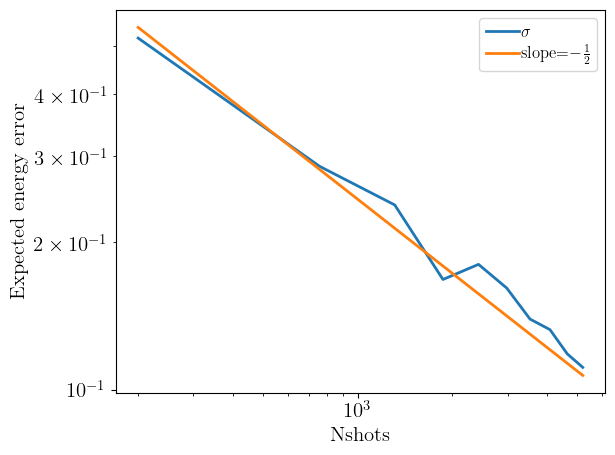

In [165]:
plt.plot(shots_list, std_ls, label=r'$\sigma$')
plt.plot(shots_list, [fitted_c*shot**(-0.5) for shot in shots_list], label=r'slope=$-\frac{1}{2}$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Nshots')
plt.ylabel('Expected energy error')
plt.legend()
plt.tight_layout()
plt.savefig('logscale.pdf')

In [142]:
import csv
with open('clt.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in loss_list:
        writer.writerow([item])